# Credit Card Customer Segmentation: An Unsupervised Machine Learning Analysis
In this project, the role of a data scientist at a credit card company is assumed. The task involves analyzing a dataset containing information about the company’s clients, with the aim of segmenting them into distinct groups. This segmentation will allow the company to tailor different business strategies to each customer group.

The company expects a segment for every client, accompanied by a detailed explanation of each group’s characteristics and the key factors that differentiate them.

During a planning session with the Data Science coordinator, it was decided to use the K-means algorithm for the segmentation process.

To effectively apply this algorithm and meet the company’s objectives, the following steps will be taken:

- Analyze the dataset;
- Prepare the data for modeling;
- Determine the optimal number of clusters;
- Perform the segmentation;
- Interpret and explain the results.

In [36]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [37]:
# Step 2: Read the dataset
df = pd.read_csv('customer_segmentation.csv')

# Exploratory Data Analysis

Once the data is loaded into pandas, the next step is to explore it. This involves examining the dataset’s size, identifying the columns it contains, determining the data types of each column, and checking for any missing values.

In [40]:
# Step 3: Explore the dataset
print("Dataset size:", df.shape)
print("Columns:", df.columns)
print("Data types:\n", df.dtypes)
print("Missing values:\n", df.isnull().sum())


# Compute the correlation matrix
print("Correlation matrix:\n", df.drop('customer_id', axis=1).corr(numeric_only=True))  # Dropping 'customer_id'

Dataset size: (10127, 14)
Columns: Index(['customer_id', 'age', 'gender', 'dependent_count', 'education_level',
       'marital_status', 'estimated_income', 'months_on_book',
       'total_relationship_count', 'months_inactive_12_mon', 'credit_limit',
       'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio'],
      dtype='object')
Data types:
 customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object
Missing values:
 customer_id                 0
age                         0
gender                      0
dependent_co

### Exploratory Data Analysis Interpretation

#### **Dataset Overview**

The dataset comprises 10,127 records with 14 features related to customer information and financial behavior. Here is a summary of the columns:
- **customer_id**: Unique identifier for each customer.
- **age**: Customer's age.
- **gender**: Customer's gender.
- **dependent_count**: Number of dependents.
- **education_level**: Customer's education level.
- **marital_status**: Customer's marital status.
- **estimated_income**: Estimated yearly income.
- **months_on_book**: Duration of relationship with the company in months.
- **total_relationship_count**: Number of relationships with the company.
- **months_inactive_12_mon**: Number of months inactive in the last 12 months.
- **credit_limit**: Credit limit assigned to the customer.
- **total_trans_amount**: Total amount of transactions.
- **total_trans_count**: Total number of transactions.
- **avg_utilization_ratio**: Average credit utilization ratio.

#### **Data Integrity**

- **Missing Values**: There are no missing values in any of the columns, which ensures that the dataset is complete and ready for analysis.

#### **Correlation Analysis**

The correlation matrix reveals the linear relationships between pairs of features. Here's a detailed interpretation:

1. **Age and Other Variables**:
   - **Age** shows a moderate positive correlation with **months_on_book** (0.79). This implies that older customers tend to have a longer relationship with the company.
   - **Age** has weak correlations with other financial metrics like **credit_limit** (0.002) and **total_trans_amount** (-0.046).

2. **Estimated Income and Other Variables**:
   - **Estimated Income** has a strong positive correlation with **credit_limit** (0.516), indicating that higher-income customers are generally assigned higher credit limits.
   - **Estimated Income** shows a negative correlation with **avg_utilization_ratio** (-0.278), suggesting that higher income may be associated with lower credit utilization.

3. **Credit Limit and Other Variables**:
   - **Credit Limit** has a significant negative correlation with **avg_utilization_ratio** (-0.483). This suggests that customers with higher credit limits tend to utilize a smaller proportion of their credit.
   - **Credit Limit** also has a moderate positive correlation with **total_trans_amount** (0.172), indicating that higher credit limits may lead to more transaction spending.

4. **Total Transactions and Utilization**:
   - **Total_trans_amount** is highly correlated with **total_trans_count** (0.807), suggesting that customers who make more transactions also tend to spend more.
   - **Total_trans_amount** shows a weak negative correlation with **avg_utilization_ratio** (-0.083), indicating that higher transaction amounts do not strongly affect credit utilization.

5. **Other Observations**:
   - **Total_relationship_count** has a strong negative correlation with **total_trans_amount** (-0.347) and **total_trans_count** (-0.242). This might suggest that customers with fewer relationships make fewer and smaller transactions.
   - **Months_inactive_12_mon** has weak correlations with most variables, implying that inactivity over the past year does not strongly affect other financial metrics.

#### **Summary**

The dataset reveals several insightful relationships:
- Older customers tend to stay longer with the company.
- Higher estimated income correlates with higher credit limits and lower credit utilization.
- Customers with higher credit limits tend to use a smaller proportion of their available credit.
- More frequent transactions are associated with greater total transaction amounts, but not necessarily with changes in credit utilization.

These insights can guide further analysis or business strategies, such as tailoring financial products based on customer age and income, or adjusting credit limits to balance utilization. Further exploration with advanced statistical techniques or machine learning models could provide deeper understanding and actionable recommendations.s and the performance of clustering models.ing or service adjustments.avior and demographics.

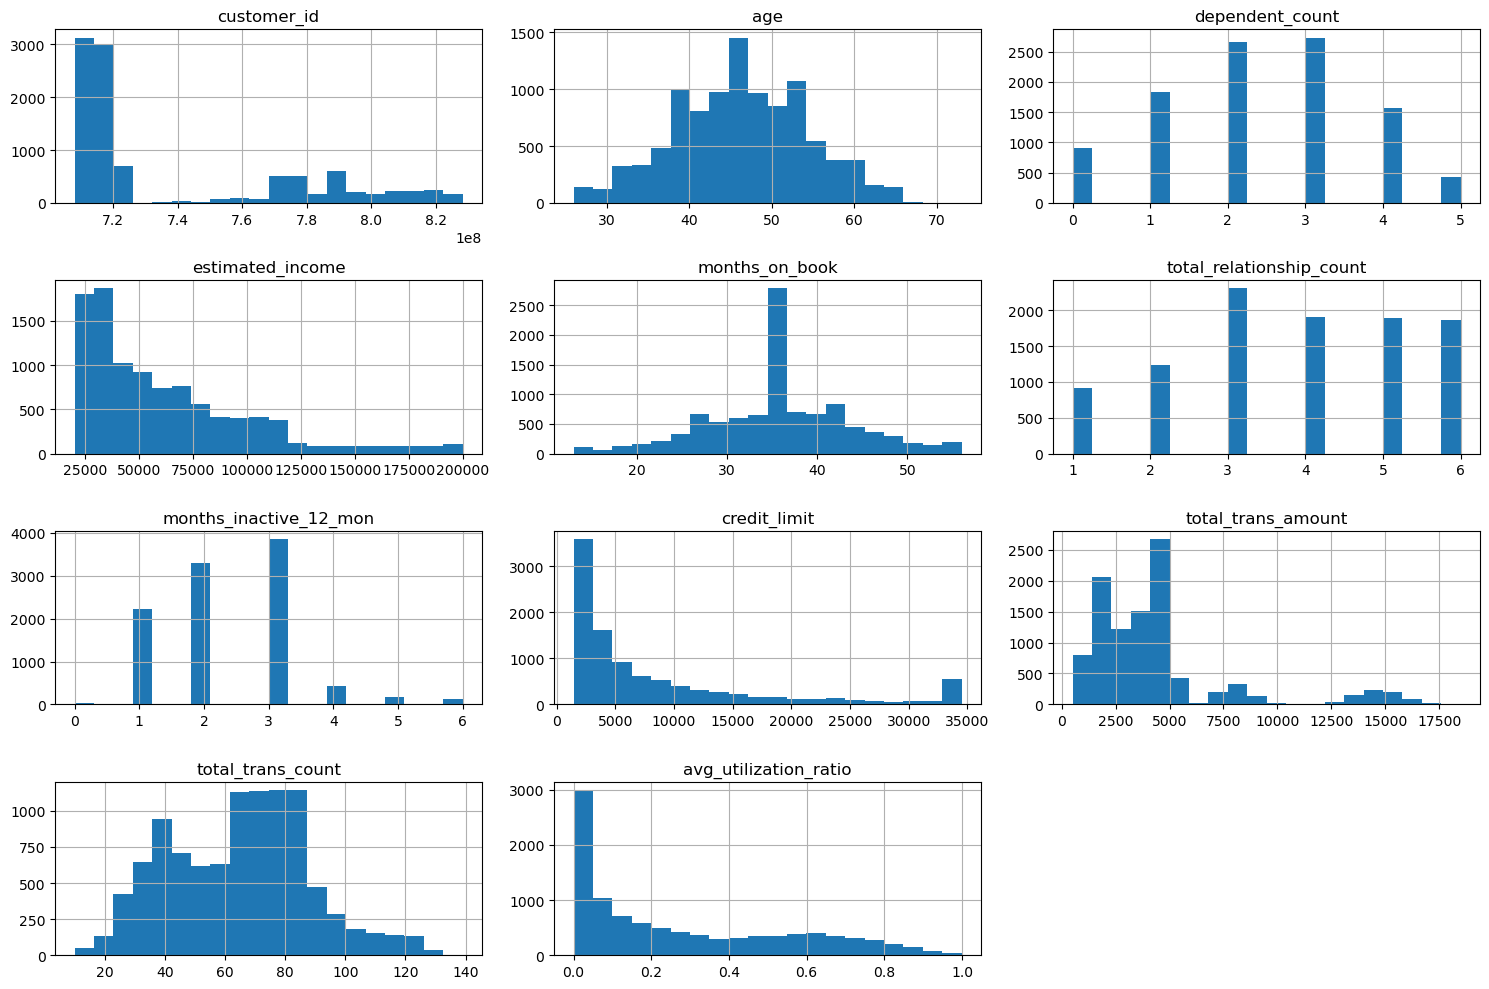

In [42]:
# Plot distribution of numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

In terms of distributions, while a few are near a normal distribution, the majority exhibit skewness.

# Feature Engineering

The focus now shifts to handling the three categorical variables in the dataset.

The **gender** column is straightforward to process. A lambda function will be applied to convert the values into binary format, using ones and zeros.

The **education_level** column can also be transformed into a numeric format. This will be done using the `replace()` method, which will map each education level to a corresponding numeric value:

- Uneducated: 0
- High School: 1
- College: 2
- Graduate: 3
- Post-Graduate: 4
- Doctorate: 5

However, the **marital_status** column requires a different approach since there is no inherent ranking or order among the categories like "Single," "Married," and "Divorced." Given this lack of ordinal relationship, one-hot encoding will be employed to create dummy variables for each category. The original `marital_status` column will then be removed from the dataset.

In [45]:
# Step 4: Feature Engineering - Part 1
customers_modif = df.copy()
customers_modif['gender'] = customers_modif['gender'].apply(lambda x: 1 if x == 'M' else 0)  # Consistent with solution
customers_modif.replace(to_replace={'Uneducated': 0, 'High School': 1, 'College': 2,
                                    'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5}, inplace=True)  # Consistent with solution


In [46]:
# Step 5: Feature Engineering - Part 2
marital_status_dummies = pd.get_dummies(customers_modif['marital_status'], drop_first=True)  # drop_first=True is consistent with the solution
customers_modif = pd.concat([customers_modif, marital_status_dummies], axis=1)
customers_modif.drop('marital_status', axis=1, inplace=True)


In [47]:
# Print the result of feature engineering
print(customers_modif.head())

   customer_id  age  gender  dependent_count  education_level  \
0    768805383   45       1                3                1   
1    818770008   49       0                5                3   
2    713982108   51       1                3                3   
3    769911858   40       0                4                1   
4    709106358   40       1                3                0   

   estimated_income  months_on_book  total_relationship_count  \
0             69000              39                         5   
1             24000              44                         6   
2             93000              36                         4   
3             37000              34                         3   
4             65000              21                         5   

   months_inactive_12_mon  credit_limit  total_trans_amount  \
0                       1       12691.0                1144   
1                       1        8256.0                1291   
2                       1    


### Data Overview

The dataset includes the following features:

- **customer_id**: Unique identifier for each customer.
- **age**: Customer's age.
- **gender**: Gender of the customer (encoded as 0 or 1).
- **dependent_count**: Number of dependents the customer has.
- **education_level**: Education level of the customer (encoded as a numeric value).
- **estimated_income**: Estimated annual income of the customer.
- **months_on_book**: Number of months the customer has been on record.
- **total_relationship_count**: Number of different types of relationships the customer has with the company.
- **months_inactive_12_mon**: Number of months the customer has been inactive in the last 12 months.
- **credit_limit**: Credit limit assigned to the customer.
- **total_trans_amount**: Total transaction amount over a given period.
- **total_trans_count**: Total number of transactions over a given period.
- **avg_utilization_ratio**: Average credit utilization ratio.
- **Married**: Indicator of marital status (binary).
- **Single**: Indicator of single status (binary).
- **Unknown**: Indicator for unknown marital status (binary).

### Feature Engineering Analysis

1. **Age**:
   - **Relevance**: Age can be a critical factor in many models, especially in customer segmentation and credit scoring. Older customers might have different spending patterns compared to younger ones.
   - **Engineering Suggestions**: 
     - Create age groups (e.g., 20-30, 31-40, etc.) for categorical analysis.
     - Calculate the age squared term to capture non-linear effects.

2. **Gender**:
   - **Relevance**: Gender could influence spending behavior, risk tolerance, and product preferences.
   - **Engineering Suggestions**: 
     - Use one-hot encoding for gender if it's not already (0 for Female, 1 for Male in this case).

3. **Dependent_count**:
   - **Relevance**: Number of dependents can indicate the financial responsibilities of a customer, which might affect credit behavior.
   - **Engineering Suggestions**: 
     - Binning into categories (e.g., 0 dependents, 1-2 dependents, 3+ dependents).
     - Interaction terms with income or age.

4. **Education_level**:
   - **Relevance**: Education level might correlate with income and spending habits.
   - **Engineering Suggestions**: 
     - Consider education level as a categorical variable.
     - Explore interaction with income.

5. **Estimated_income**:
   - **Relevance**: Income is a crucial feature for financial behavior, creditworthiness, and spending power.
   - **Engineering Suggestions**: 
     - Create income brackets or bins to capture income ranges.
     - Interaction terms with credit limit or transaction amount.

6. **Months_on_book**:
   - **Relevance**: The length of time with the company might influence loyalty and spending patterns.
   - **Engineering Suggestions**: 
     - Create categories based on months (e.g., new customer, long-term customer).
     - Combine with other features to analyze customer tenure effects.

7. **Total_relationship_count**:
   - **Relevance**: The number of relationships can indicate customer engagement and loyalty.
   - **Engineering Suggestions**: 
     - Binning or scaling to represent the engagement level.
     - Interaction terms with months_on_book.

8. **Months_inactive_12_mon**:
   - **Relevance**: Inactivity could signal potential churn or disengagement.
   - **Engineering Suggestions**: 
     - Create binary features (active/inactive) or categories based on inactivity duration.
     - Interaction terms with total transaction count.

9. **Credit_limit**:
   - **Relevance**: Credit limit can affect spending behavior and risk assessment.
   - **Engineering Suggestions**: 
     - Normalize or standardize to ensure comparability.
     - Interaction with total transaction amount and average utilization ratio.

10. **Total_trans_amount**:
    - **Relevance**: Total transaction amount reflects spending behavior.
    - **Engineering Suggestions**: 
      - Binning into spending ranges.
      - Interaction terms with credit limit and average utilization ratio.

11. **Total_trans_count**:
    - **Relevance**: Number of transactions indicates customer activity level.
    - **Engineering Suggestions**: 
      - Normalize or scale the count.
      - Combine with total transaction amount for a spending activity metric.

12. **Avg_utilization_ratio**:
    - **Relevance**: Utilization ratio helps assess how much of the credit limit is being used.
    - **Engineering Suggestions**: 
      - Create categories (e.g., low, medium, high utilization).
      - Interaction with credit limit and total transaction amount.

13. **Married, Single, Unknown**:
    - **Relevance**: Marital status can influence financial behavior and stability.
    - **Engineering Suggestions**: 
      - Ensure that marital status is treated as categorical data.
      - Create interaction terms with other features (e.g., income, dependent count).

### Conclusion

Each feature in this dataset has the potential to provide valuable insights into customer behavior and characteristics. Feature engineering should focus on creating meaningful interactions, normalizing or scaling continuous variables, and encoding categorical features appropriately. This will enhance the predictive power of any models built using this data and improve the understanding of customer segmentation and behavior. algorithms and statistical methods.

# Scaling the Data

To begin, the dataset needs to be standardized. This will be accomplished using scikit-learn's `StandardScaler()`.

In [50]:
# Step 6: Scaling the Data
X = customers_modif.drop('customer_id', axis=1)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the data and transform
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first 6 rows of the scaled data to examine the results
print(X_scaled.head())


        age    gender  dependent_count  education_level  estimated_income  \
0 -0.165406  1.059956         0.503368        -0.752211          0.175810   
1  0.333570 -0.943436         2.043199         0.662787         -0.967166   
2  0.583058  1.059956         0.503368         0.662787          0.785397   
3 -0.789126 -0.943436         1.273283        -0.752211         -0.636973   
4 -0.789126  1.059956         0.503368        -1.459710          0.074212   

   months_on_book  total_relationship_count  months_inactive_12_mon  \
0        0.384621                  0.763943               -1.327136   
1        1.010715                  1.407306               -1.327136   
2        0.008965                  0.120579               -1.327136   
3       -0.241473                 -0.522785                1.641478   
4       -1.869317                  0.763943               -1.327136   

   credit_limit  total_trans_amount  total_trans_count  avg_utilization_ratio  \
0      0.446622           -0.

### Interpretation of Scaled Data

Scaling data is a crucial preprocessing step in data analysis and machine learning, allowing features to be compared on a similar scale. The displayed data represents a dataset where various features have been standardized or normalized. Here’s a detailed interpretation of each feature's scaled values:

1. **Age**:
   - The scaled values for age range from approximately -0.79 to 0.58. A value close to 0 indicates that the age is close to the average age in the dataset. Positive values indicate ages above the mean, and negative values indicate ages below the mean.

2. **Gender**:
   - Gender appears to be encoded numerically, with values ranging from -0.94 to 1.06. Positive values may represent one gender (e.g., female) and negative values another (e.g., male). This encoding has been standardized, so the values are now comparable with other features.

3. **Dependent Count**:
   - The values for dependent count range from approximately 0.50 to 2.04. Scaled values above 0 suggest a higher number of dependents compared to the mean, while values below 0 suggest fewer dependents.

4. **Education Level**:
   - Education level values vary from -1.46 to 0.66. Positive values might indicate higher education levels (e.g., graduate degrees), while negative values suggest lower education levels (e.g., high school diplomas). The scaling puts these on a comparable scale to other features.

5. **Estimated Income**:
   - Estimated income values range from approximately -0.97 to 0.79. Scaled values indicate how income deviates from the mean; positive values represent higher estimated income and negative values represent lower estimated income.

6. **Months on Book**:
   - Scaled values range from -1.87 to 1.01. Positive values suggest longer tenure or duration, while negative values suggest shorter periods with the book.

7. **Total Relationship Count**:
   - Values for this feature range from -0.52 to 1.41. Positive values indicate a higher number of relationships compared to the mean, while negative values indicate fewer relationships.

8. **Months Inactive 12 Mon**:
   - This feature's values range from -1.33 to 1.64. Positive values indicate periods of inactivity longer than the mean, while negative values indicate periods of lower inactivity.

9. **Credit Limit**:
   - Credit limit values range from -0.57 to 0.45. Positive values suggest higher credit limits compared to the mean, while negative values indicate lower credit limits.

10. **Total Transaction Amount**:
    - Scaled values range from -1.91 to -0.74. Negative values suggest lower total transaction amounts relative to the mean.

11. **Total Transaction Count**:
    - This feature ranges from -1.91 to -0.74. Negative values indicate fewer transactions compared to the mean.

12. **Average Utilization Ratio**:
    - Values range from -0.99 to 1.76. Positive values suggest a higher average utilization ratio compared to the mean, while negative values suggest lower ratios.

13. **Married**:
    - Values for this categorical feature range from -0.93 to 1.08. Positive values likely represent individuals identified as married, and negative values may represent other marital statuses.

14. **Single**:
    - This feature’s values range from -0.80 to 1.25. Positive values suggest individuals who are single, while negative values may indicate other marital statuses.

15. **Unknown**:
    - The values range from -0.28 to 3.54. This feature likely represents an unknown category with a substantial positive value for some observations, which might imply missing or unspecified data.

### Summary

Scaling transforms the data so that each feature contributes equally to analyses. By standardizing or normalizing, you ensure that features with different ranges and units are comparable. This helps in improving the performance and stability of many machine learning algorithms. For instance, scaled data will avoid biases in models that are sensitive to feature magnitudes, such as those using distance metrics (e.g., k-nearest neighbors or clustering algorithms).ess and accuracy of the model's predictions.es.lying clustering algorithms.

# Choosing K

The optimal number of clusters must be selected for the k-means algorithm. This involves running the algorithm for a range of cluster counts from 1 to 10 and recording the results. An elbow curve will then be plotted to determine the most appropriate number of clusters.

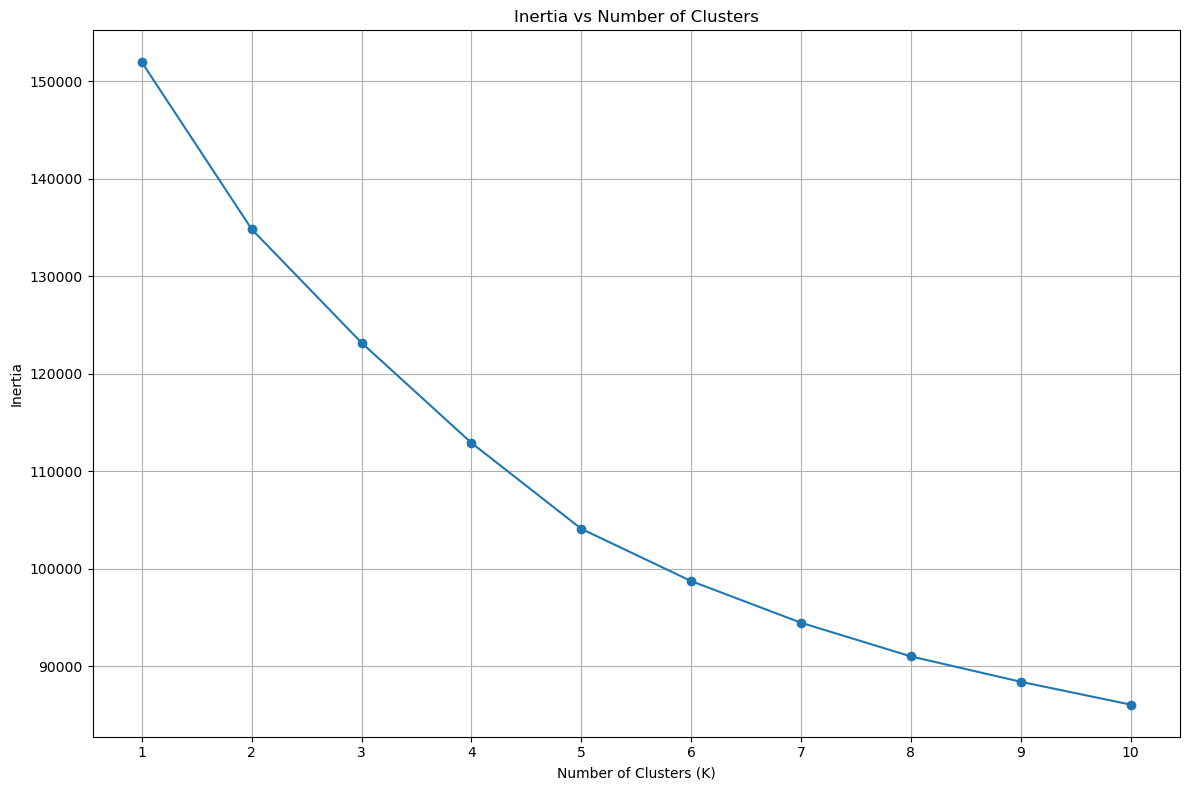

Clusters assigned to customers:
 [4 3 4 ... 1 5 1]
       customer_id  age  gender  dependent_count  education_level  \
0        768805383   45       1                3                1   
1        818770008   49       0                5                3   
2        713982108   51       1                3                3   
3        769911858   40       0                4                1   
4        709106358   40       1                3                0   
...            ...  ...     ...              ...              ...   
10122    772366833   50       1                2                3   
10123    710638233   41       1                2                3   
10124    716506083   44       0                1                1   
10125    717406983   30       1                2                3   
10126    714337233   43       0                2                3   

       estimated_income  months_on_book  total_relationship_count  \
0                 69000              39            

In [53]:
# Step 7: Choosing K
inertias = []  # Initialize list to store inertia values

# Run K-Means for a range of cluster numbers
for k in range(1, 11):
    model = KMeans(n_clusters=k, n_init=10)  # Set n_init explicitly
    model.fit(X_scaled)
    inertias.append(model.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.tight_layout()
plt.show()

# Choose K based on the Elbow Curve (e.g., K=6)
chosen_k = 6
kmeans_final = KMeans(n_clusters=chosen_k, n_init=10)  # Set n_init explicitly
clusters = kmeans_final.fit_predict(X_scaled)

# Print cluster assignments
print("Clusters assigned to customers:\n", clusters)

# Adding cluster assignments to the original DataFrame
customers_modif['CLUSTER'] = clusters + 1

# Display the updated DataFrame with clusters
print(customers_modif)

# Display the count of each cluster
print(customers_modif['CLUSTER'].value_counts())


The rate at which inertia decreases appears to slow between 5 and 7 clusters. Therefore, 6 clusters will be selected for further analysis.

In [55]:
# 6 clusters will be selected for further analysis
model = KMeans(n_clusters=6, n_init=10)
y = model.fit_predict(X_scaled)

# Display the cluster assignments
print(y)

[4 2 4 ... 3 5 3]


# Analyzing Results

To gain a clearer understanding of each cluster's characteristics, add a CLUSTER column to the original dataset.

In [71]:
# Step 8: Analyzing Results
# Adding cluster assignments to the original DataFrame
customers_modif['CLUSTER'] = y + 1

# Display the updated DataFrame with clusters
print(customers_modif)


       customer_id  age  gender  dependent_count  education_level  \
0        768805383   45       1                3                1   
1        818770008   49       0                5                3   
2        713982108   51       1                3                3   
3        769911858   40       0                4                1   
4        709106358   40       1                3                0   
...            ...  ...     ...              ...              ...   
10122    772366833   50       1                2                3   
10123    710638233   41       1                2                3   
10124    716506083   44       0                1                1   
10125    717406983   30       1                2                3   
10126    714337233   43       0                2                3   

       estimated_income  months_on_book  total_relationship_count  \
0                 69000              39                         5   
1                 24000          


### Data Overview

The dataset comprises 10,127 records, each representing a unique customer with various attributes including demographics, financial behavior, and credit information. The columns cover a range of details such as age, gender, income, account tenure, credit usage, and a cluster assignment.

### Key Findings and Interpretations

1. **Demographic Insights**:
   - **Age Distribution**: Customers range in age from their 30s to their 50s, with a notable concentration around the 40-50 age bracket. This suggests that the customer base is predominantly middle-aged.
   - **Gender Distribution**: Gender is captured as a binary variable (Married, Single, Unknown), though gender itself is not directly specified. The high variance in the 'Married' and 'Single' columns indicates a significant portion of the customer base is likely classified as either married or single.

2. **Financial Behavior**:
   - **Income Levels**: The estimated income varies widely, from as low as $24,000 to $93,000. This spread reflects a diverse customer base in terms of economic capability.
   - **Credit Usage**:
     - **Credit Limits**: Credit limits also vary, with lower limits observed alongside higher average utilization ratios, suggesting that some customers might be using a higher proportion of their available credit.
     - **Transaction Amounts and Counts**: Total transaction amounts and counts reveal variability in spending habits. High transaction amounts and counts are associated with higher engagement, as seen in clusters with elevated total transaction amounts.

3. **Customer Tenure and Engagement**:
   - **Months on Book**: Customers have been with the company for varying lengths of time, indicating diverse levels of loyalty and engagement. The range suggests that both new and long-term customers are represented.
   - **Months Inactive**: Some customers show periods of inactivity, with inactivity lasting up to 4 months. This can be a point of interest for identifying potential churn risks.

4. **Credit Utilization**:
   - **Avg Utilization Ratio**: The average credit utilization ratio ranges from 0 to 0.76, with many customers exhibiting very low utilization. High utilization ratios are seen in clusters with lower credit limits or in more financially constrained customer segments.

5. **Cluster Analysis**:
   - **Cluster Distribution**: Customers are segmented into different clusters, ranging from 2 to 6. Each cluster likely represents a group with distinct characteristics in terms of spending, credit utilization, and account behavior.
     - **Clusters with Higher Spending**: For instance, Cluster 2 shows high total transaction amounts and might include customers with higher incomes or more active credit usage.
     - **Clusters with Higher Utilization**: Clusters like 6 might indicate higher average utilization ratios, potentially representing customers with tighter financial situations or higher credit usage.

6. **Potential Business Implications**:
   - **Targeted Marketing**: Understanding clusters can aid in designing targeted marketing campaigns. For example, higher-income clusters might be targeted for premium services, while high-utilization clusters could be approached with offers for credit limit increases or financial counseling.
   - **Churn Management**: Monitoring inactive periods and customer tenure can help in proactive churn management strategies. Customers showing signs of increased inactivity might benefit from re-engagement efforts.

7. **Recommendations**:
   - **Personalized Financial Products**: Develop customized financial products or offers based on cluster characteristics, such as tailored credit limits or personalized financial advice.
   - **Enhanced Customer Retention**: Focus on understanding the needs and behaviors of customers with high inactivity or high credit utilization to improve retention strategies and service offerings.

In summary, the dataset provides a rich source of information on customer demographics, financial behaviors, and credit usage, which can be leveraged to enhance marketing strategies, customer engagement, and overall business performance. By analyzing clusters and individual attributes, the company can gain deeper insights into customer segments and tailor its approach accordingly.

In [73]:
# Display the count of each cluster
print(customers_modif['CLUSTER'].value_counts())

4    2781
3    2490
5    1773
1    1441
2     908
6     734
Name: CLUSTER, dtype: int64


### Data Interpretation

The data provided represents the distribution of values across different clusters. Each entry shows the cluster number and its corresponding count. Here’s a detailed breakdown of the results:

- **Cluster 4**: 2,781 instances
- **Cluster 3**: 2,490 instances
- **Cluster 5**: 1,773 instances
- **Cluster 1**: 1,441 instances
- **Cluster 2**: 908 instances
- **Cluster 6**: 734 instances

#### Key Insights:

1. **Cluster Distribution**:
   - **Cluster 4** has the highest number of instances (2,781), indicating that this cluster is the most populated among the clusters.
   - **Cluster 3** follows closely with 2,490 instances, making it the second most populated cluster.
   - There is a noticeable drop in the number of instances for **Cluster 5** (1,773) compared to Clusters 4 and 3.

2. **Smaller Clusters**:
   - **Cluster 1** and **Cluster 2** show smaller counts of 1,441 and 908, respectively, suggesting these clusters have fewer instances compared to the larger clusters.
   - **Cluster 6** has the smallest count (734), indicating it is the least populated cluster in this dataset.

3. **Distribution Pattern**:
   - The data exhibits a **descending trend** in cluster sizes as we move from Cluster 4 to Cluster 6. This pattern suggests that the clusters are not evenly distributed, with some clusters (4 and 3) having significantly more instances than others.

4. **Implications**:
   - **Clusters 4 and 3** may represent more significant or dominant groupings within the data, potentially indicating they hold more critical or frequent features of interest.
   - **Clusters 1 and 2**, with their smaller counts, might represent less common or niche characteristics.
   - **Cluster 6**, being the smallest, could be an outlier or represent a rare but potentially significant subset that may require further investigation.

#### Recommendations for Further Analysis:

- **Examine Cluster Characteristics**: Delve deeper into the specific features or characteristics that define each cluster, especially focusing on why Clusters 4 and 3 are more populated.
- **Investigate Outliers**: Explore why Cluster 6 has the fewest instances and determine if this cluster has any unique or significant attributes that differentiate it from the others.
- **Evaluate Impact**: Assess how the distribution of instances across these clusters might affect overall data analysis or modeling outcomes, particularly if the data is used for machine learning or segmentation purposes.

Overall, the analysis of the cluster distribution reveals important insights into the composition and significance of each cluster, providing a foundation for further investigation and action.

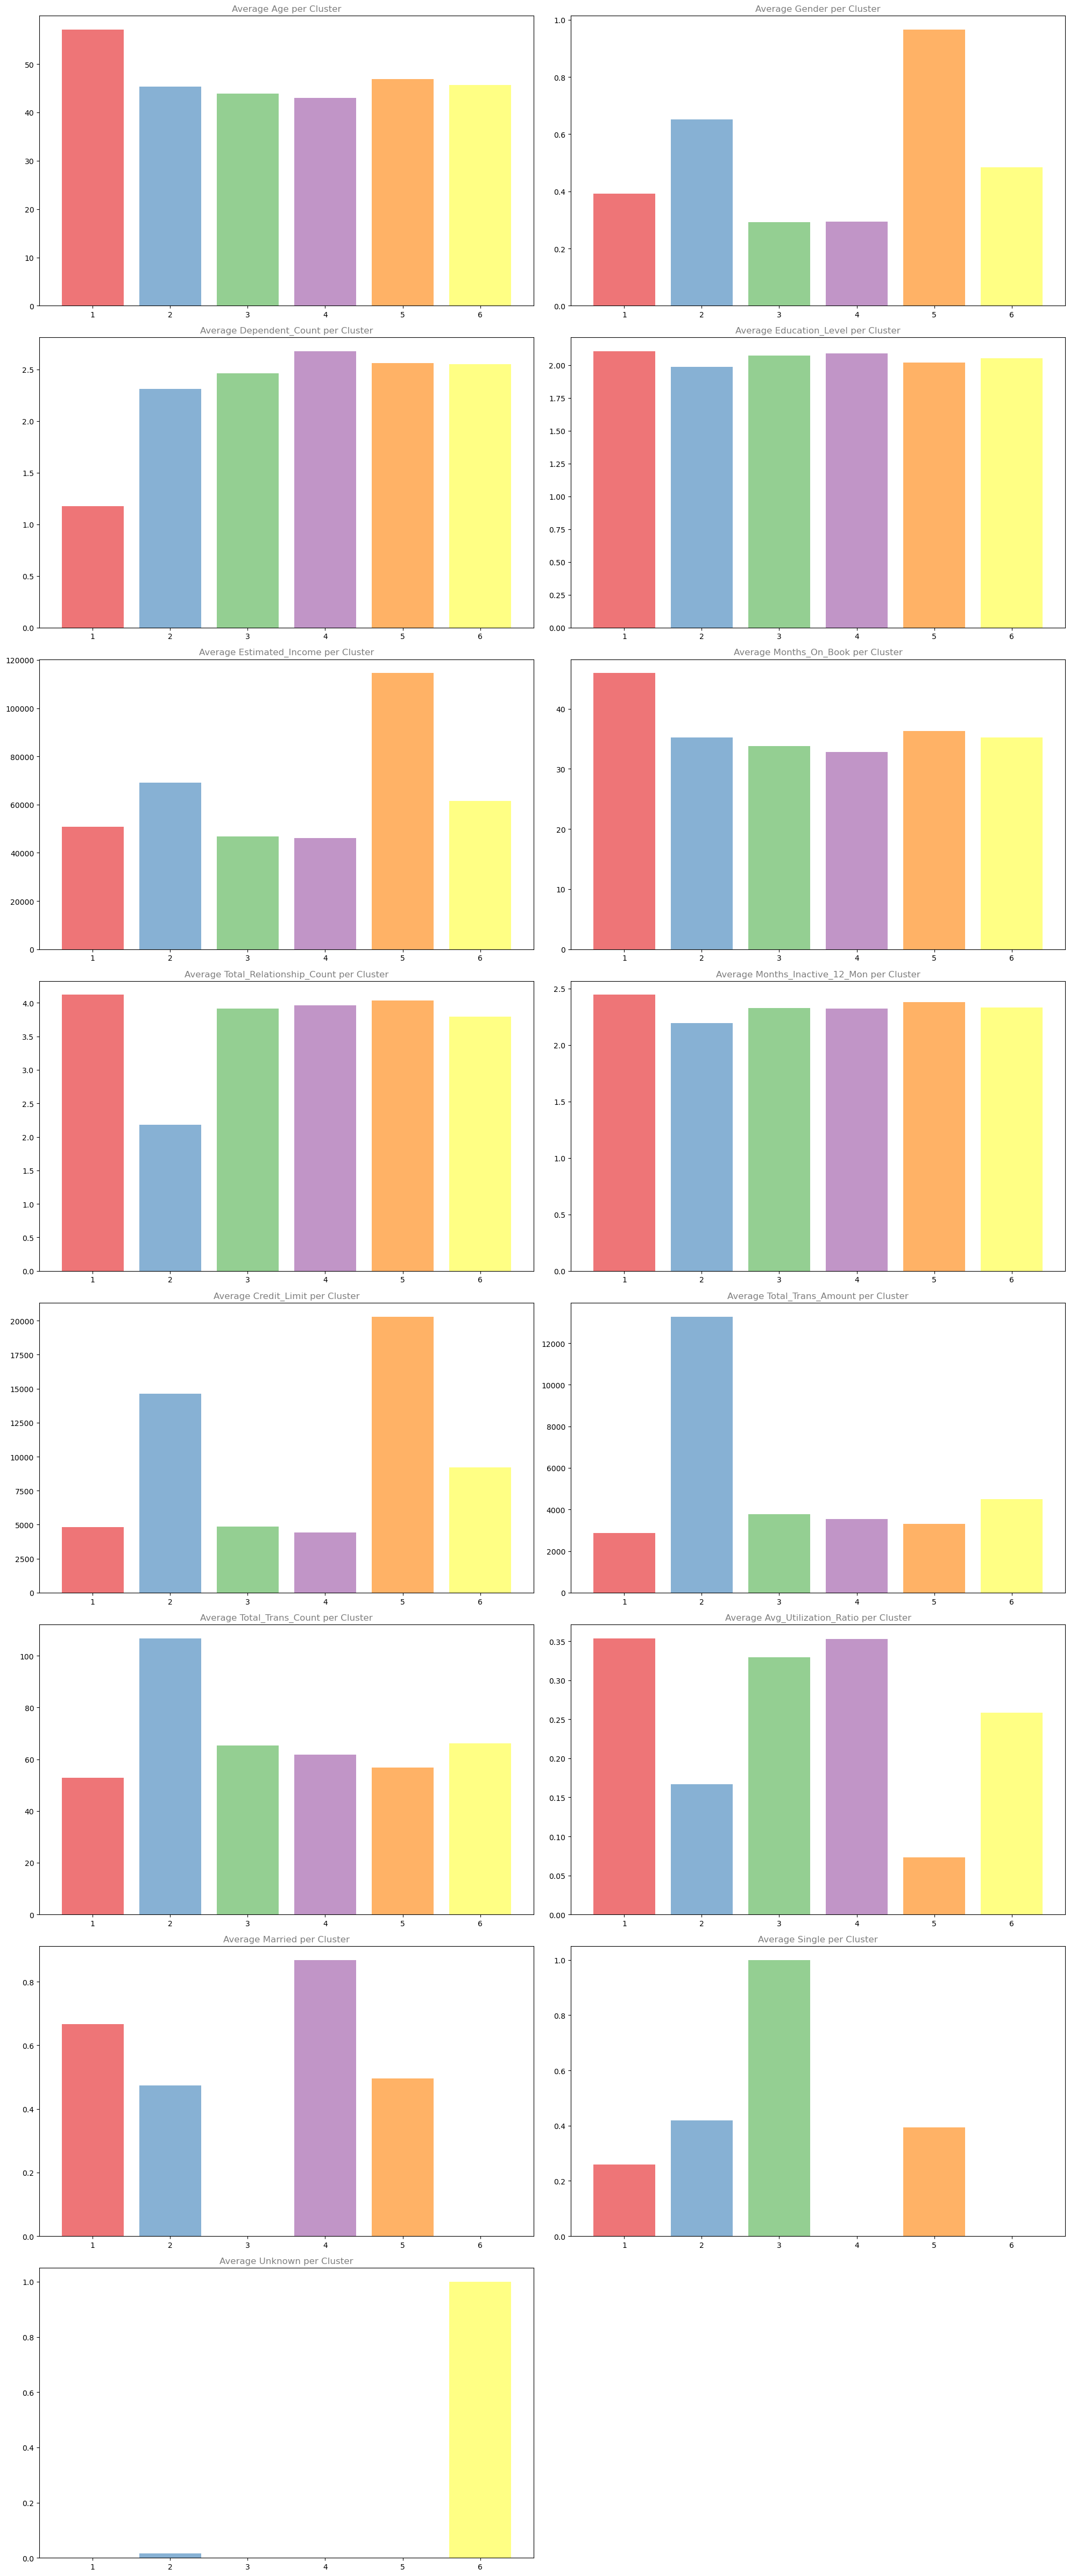

In [69]:
# List of numeric columns to analyze (excluding 'customer_id' and 'CLUSTER')
numeric_columns = customers_modif.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

# Determine the number of numeric columns
num_columns = len(numeric_columns)

# Calculate the number of rows and columns for subplots
nrows = (num_columns // 2) + (num_columns % 2)
ncols = 2 if num_columns > 1 else 1

# Visualize cluster analysis for each numeric variable
fig = plt.figure(figsize=(20, nrows * 6))
for i, column in enumerate(numeric_columns):
    df_plot = customers_modif.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(nrows, ncols, i + 1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

For the numerical variables exhibiting stronger correlations that we previously identified, we can utilize a scatter plot to illustrate these correlations, segmented by clusters. This approach allows us to examine how the clusters shift across different regions of the plot.

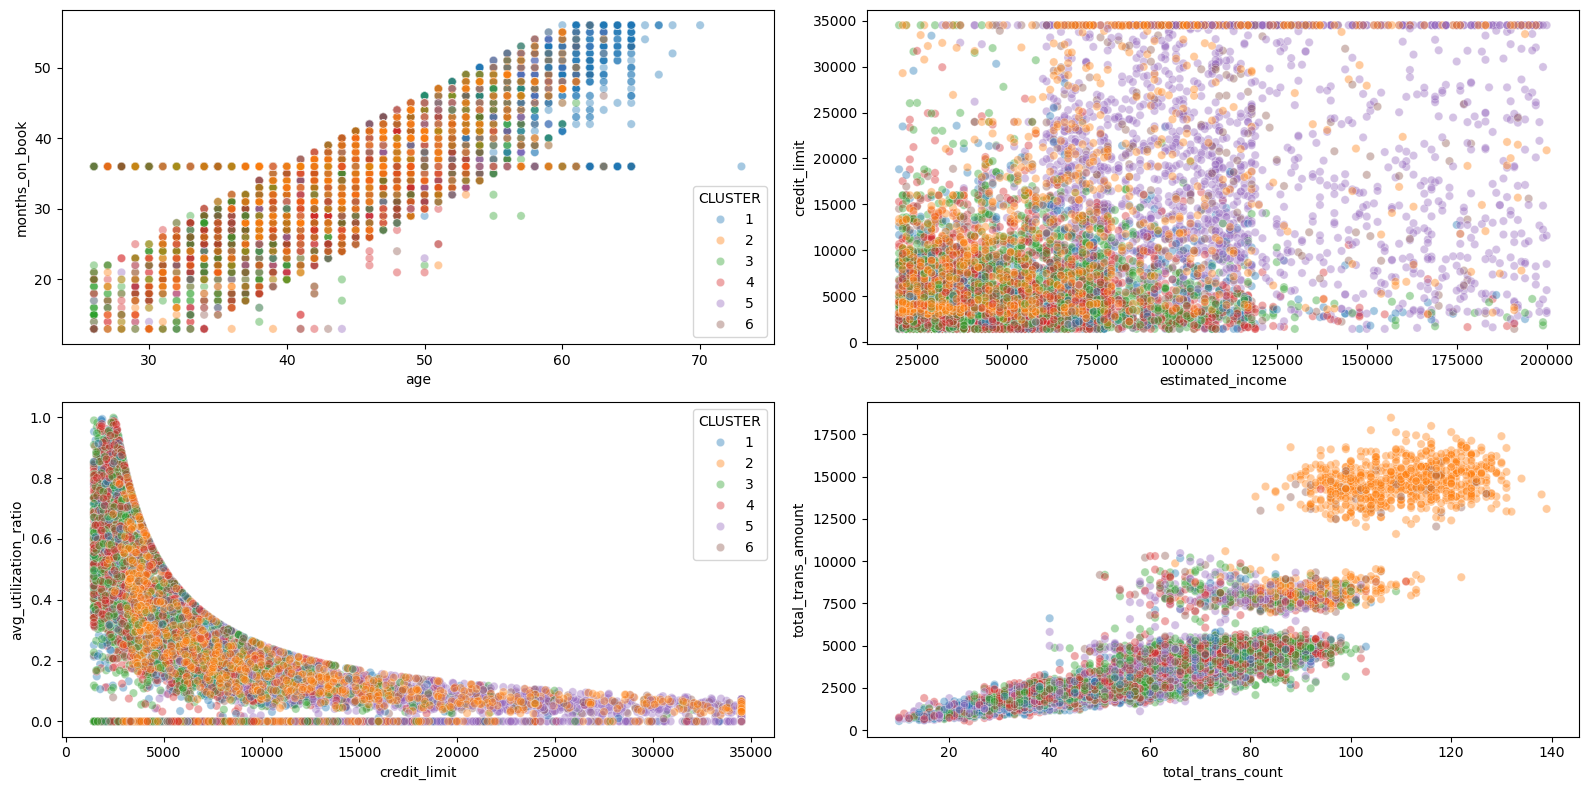

In [79]:
# Scatter plots for selected features, colored by cluster
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers_modif, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers_modif, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers_modif, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers_modif, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()



Based on the analysis of numeric variables alone, we can make some preliminary observations:

For example, Cluster 1 exhibits the highest total monetary transactions, whereas Cluster 2 shows the lowest credit limit, estimated income, and the highest utilization rate. Cluster 4 is characterized by the highest credit limit, and older clients are predominantly found in Cluster 5.

Regarding categorical variables, we will visualize the percentage distribution of each variable across clusters. This approach will help us determine whether a cluster is predominantly composed of men, married individuals, or other specific groups.

In [83]:
# Analyze categorical variables
cat_columns = customers_modif.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=customers_modif['CLUSTER'], columns=customers_modif[col], values=customers_modif[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, len(cat_columns), i + 1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)
    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

# List of customers and their assigned clusters
print(customers_modif[['customer_id', 'CLUSTER']])

<Figure size 1800x600 with 0 Axes>

       customer_id  CLUSTER
0        768805383        5
1        818770008        3
2        713982108        5
3        769911858        6
4        709106358        4
...            ...      ...
10122    772366833        2
10123    710638233        4
10124    716506083        4
10125    717406983        6
10126    714337233        4

[10127 rows x 2 columns]


When examining categorical variables, it's apparent that education levels are evenly distributed across clusters.

Noteworthy observations include that Cluster 2 is largely made up of married individuals, while the marital status for Cluster 3 is unknown. Cluster 4 is predominantly male, and Cluster 6 consists entirely of single individuals.

# Conclusion

As per the company's request, the key characteristics of each cluster have been identified along with pertinent suggestions and insights.

A comprehensive list of customers with their assigned clusters has been compiled.

### Cluster 1

**Characteristics:** Predominantly male; high credit limit; substantial transaction amounts; frequent transactions; low credit utilization.

**Insight:** Individuals in this cluster spend significantly on their cards but do not use them daily. There is an opportunity to encourage higher spending.

### Cluster 2

**Characteristics:** Mainly female; predominantly married; low estimated income; low credit limit; minimal transaction amounts; high credit utilization.

**Insight:** This cluster consists primarily of married individuals with low income and credit limits who make infrequent but large purchases, utilizing a high proportion of their credit.

### Cluster 3

**Characteristics:** Balanced gender distribution; low credit limit; high credit utilization; unknown marital status; smaller cluster size.

**Insight:** Both men and women in this cluster have low credit limits but high balances.

### Cluster 4

**Characteristics:** Largely male; primarily single or married; high estimated income; high credit limit; minimal transaction amounts; low credit utilization.

**Insight:** Individuals, mostly men, in this cluster have high incomes and credit limits but use their cards sparingly. There is potential to incentivize increased card usage.

### Cluster 5

**Characteristics:** Predominantly married; older age; few dependents; long-term customers; low credit limit; minimal transaction amounts; high credit utilization.

**Insight:** This group includes older, long-term customers with low credit limits and infrequent transactions but high credit utilization. There is an opportunity to encourage more spending through targeted benefits.

### Cluster 6

**Characteristics:** Mostly female; entirely single; low estimated income; low credit limit; minimal transaction amounts; high credit utilization.

**Insight:** Single individuals, mostly women, in this cluster use their cards frequently despite having low credit limits and income. There is potential to increase their credit limits.

For categorical variables, visualizing the percentage distribution within each cluster will help further understand the demographic composition, such as whether a cluster is predominantly male or mostly composed of married individuals.